# Digital signal processing - 10

| ** Title ** | Digital signal processing |
| --- | --- |
| ** Author ** | Alexander Kapitanov |
| ** Contact ** | sallador@bk.ru |
| ** Project lang ** | Python |
| ** Packages ** | numpy, scipy, matplotlib |
| ** License ** | GNU GPL 3.0 |

## Introduction

Here is a tutorial on the basics of ** digital signal processing ** using the Python programming language. It is assumed that the reader has basic knowledge of higher mathematics, as well as knows the Python language and at least superficially knows various python libraries - numpy / scipy, matplotlib and others.

For MATLAB / GNU Octave users, mastering the material from the point of view of the program code will not be difficult, since the main functions and their attributes are largely identical and similar to methods from python libraries.


## Averaging over frequency and time

This section focuses on another important topic that often confuses developers when creating digital signal processing applications. Let's see how the signal spectrum changes when it accumulates in time and frequency. To do this, we set the input harmonic action:

$ s (t) = A \cdot cos (\frac {2 \pi \cdot t} {T}) $,

and add the additive white Gaussian noise (normal distribution) `AWGN` to it:

Probability density function:
$ f (x) = \frac {1} {\sigma \sqrt {2 \pi}} e ^ {- \frac {(x- \mu) ^ 2} {2 \sigma ^ 2}} $

where $ \mu $ is the mathematical expectation (mean value of a random process), and $ \sigma $ is the standard deviation.

So the input signal is:

$ s (t) = A \cdot cos (\frac {2 \pi \cdot t} {T}) + N (\mu, \sigma) $.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from scipy.fftpack import fft, fftshift
from scipy.signal.windows import kaiser, flattop

# Matplotlib default params
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
# plt.rcParams['legend.loc'] = 'best'

For the convenience of the analysis, we will write the `signals_compare` function, the purpose of which is to plot the spectrum from the input noisy signal at different` freq` frequencies.

The `l` parameter specifies the number of frequency and time averaging.

** Main loop: **
A signal of length `n * l` arrives at the input of the system, where` l` is the number of averaging, and `n` is the length of the FFT.

1. Calculate the FFT of a signal of length `n`,
2. We calculate the sum of signals of length `n` over` l` partitions (averaging), from the resulting sum we calculate the FFT,
3. Calculate `l` FFT from signals of length` n`, and then average the results obtained.

Notes:
- Obviously, the summation of the FFT series should be done after taking the ** module ** operation, since when adding components with different phases, loss of information (signal) is possible.
- Frequency parameters are selected in a special way in order to show the existing nuances.
- The length of the FFT in all cases is set constant and equal to N = 512 samples.
- For ease of analysis, normalized spectra are considered on a logarithmic scale.

Thus, let's look at the spectral components in all three cases:

In [2]:
def freqtime_compare(freq=201, suptitle='', l=1):
    n = 512
    m = n*l

    # Add AWGN
    np.random.seed(42)
    awgn = np.random.normal(0, 9*1e-2, m)

    # Input signal
    t = np.linspace(0, 1, m)

    x = np.cos(2*np.pi*freq*t) + awgn
    x1 = x.reshape(l, n)
    x2 = x.reshape(l, n).sum(0)

    # FFT
    Xx = np.abs(fft(x[:n], n))[:n//2]
    X1 = (np.abs(fft(x1, n))).sum(axis=0)[:n//2]
    X2 = np.abs(fft(x2, n))[:n//2]

    Xxlog = 20*np.log10(Xx / Xx.max())
    X1log = 20*np.log10(X1 / X1.max())
    X2log = 20*np.log10(X2 / X2.max())
    
    fn = np.linspace(0, 0.5, n//2)
    
    # Plot
    plt.figure(figsize=(14, 2), dpi=120)
    plt.suptitle(suptitle)
    plt.subplot(1, 3, 1)
    plt.plot(fn, Xxlog, color='C0', label=f'N={n}')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.plot(fn, X1log, color='C2', label='Avg (freq)')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 3)
    plt.plot(fn, X2log, color='C3', label='Avg (time)')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')

#### Number of averaging: 1

In the absence of averaging over frequency or time, the spectra graphs completely coincide with the FFT module of the original signal.

- Left plot: FFT of a signal of length N
- Middle plot: FFT of the frequency averaged signal,
- Right plot: FFT of the time-averaged signal.

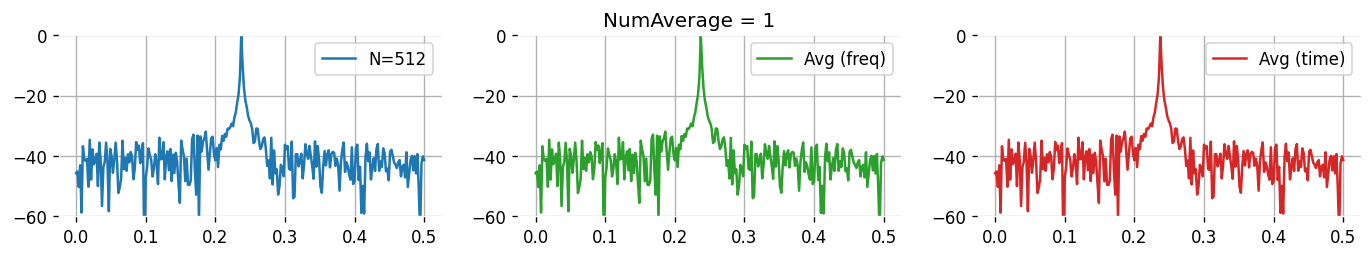

In [3]:
freqtime_compare(freq=121*1, l=1, suptitle='NumAverage = 1')

#### Number of averages: 15 and 150, signal frequency is a multiple of the number of averages

By increasing the number of averaging, the spectra begin to change with the accumulation of signals in the frequency and time domains. In the particular case, when the signal frequency is a multiple of the number of averaging, we have the following:

** Frequency averaging **
- The spectrum does not change its amplitude value at the signal frequency,
- At other frequencies, uncorrelated white noise is averaged
   * Reduces the level of noise emissions,
   * The noise level reaches a certain level,
   * If the number of averaging tends to infinity, the noise spectrum is rectified to a constant value.

** Time averaging **
- The Signal noise ratio (SNR) increases in proportion to the increase in averaging,
- The noise level is reduced.

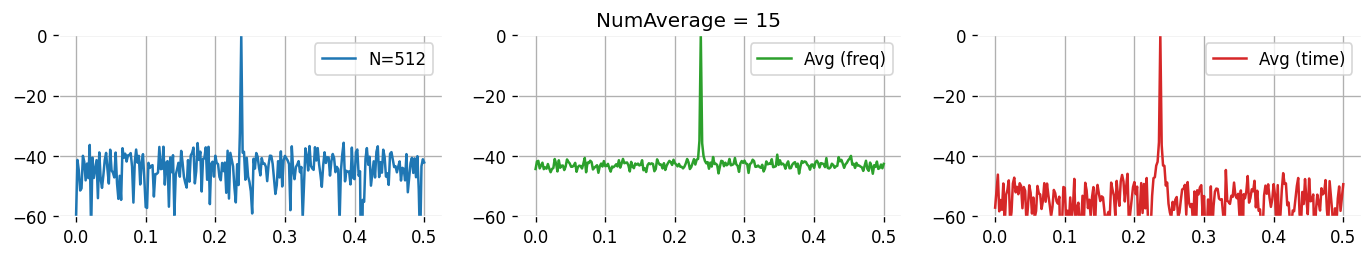

In [4]:
l_avg = 15
freqtime_compare(freq=121*l_avg, l=l_avg, suptitle=f'NumAverage = {l_avg}')

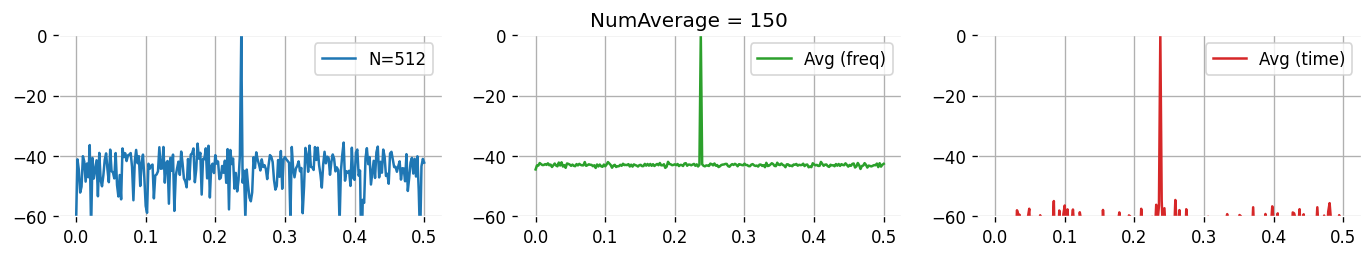

In [5]:
l_avg = 150
freqtime_compare(freq=121*l_avg, l=l_avg, suptitle=f'NumAverage = {l_avg}')

#### Number of averages: 15, signal frequency is not a multiple of the number of averages

By increasing the number of averaging, the spectra begin to change with the accumulation of signals in the frequency and time domains. In the case when the signal frequency is not a multiple of the FFT length, time averaging gives completely opposite results.

** Frequency averaging **
- Same properties as before.

** Time averaging **
- The noise level increases significantly,
- Bursts of noise are still not smoothed out.

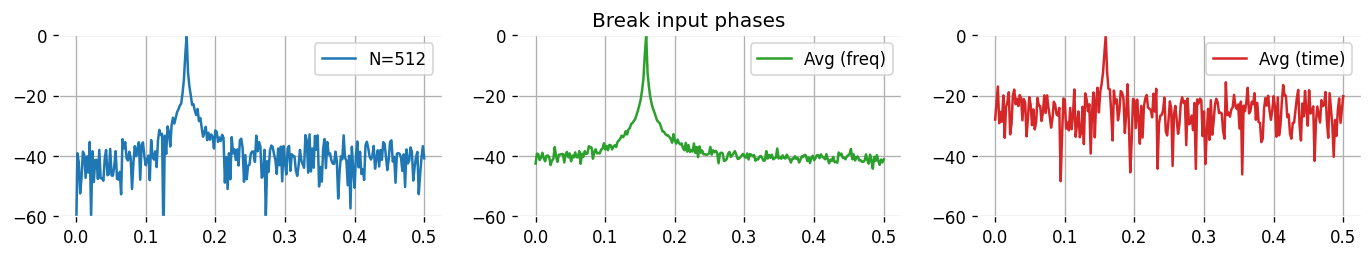

In [6]:
freqtime_compare(freq=1210, l=15, suptitle='Break input phases')

As you can see, * averaging over time * leads to different results depending on the frequency multiple of the signal to the FFT length. In order to understand the differences in results, let's look at the noisy signal in the time domain in both cases.

In [7]:
def time_compare(freq=201, l=1):
    n = 512
    m = n*l

    np.random.seed(42)
    x = np.cos(2*np.pi*freq*np.linspace(0, 1, m)) + np.random.normal(0, 9*1e-1, m)
    y = x.reshape(l, n).sum(axis=0) / l

    plt.figure(figsize=(9, 3), dpi=80)
    plt.plot(y, color='C'+str(l), label=f'Averages = {l}')
    plt.legend(loc='upper left')
    plt.xlim([0, n])
    plt.tight_layout()

** Option 1: The initial phases of the averaged signals coincide **

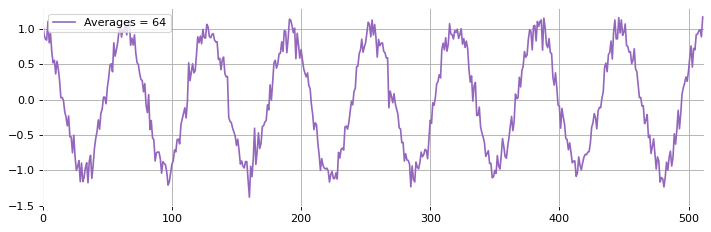

In [8]:
time_compare(freq=512, l=64)

** Option 2: The initial phases of the averaged signals differ **

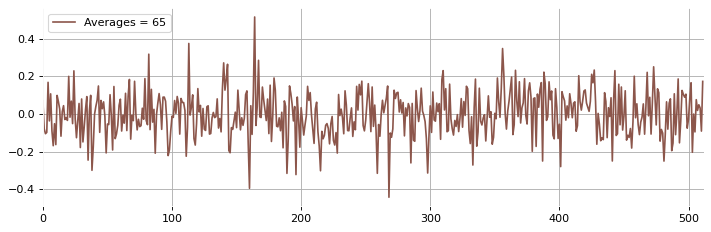

In [9]:
time_compare(freq=512, l=65)

From the graphs presented above, it can be seen that if the phases of the summed components coincide, the waveform is preserved. Otherwise, the waveform is a noise-like random process.

Thus, in the general case, it is impossible to use averaging ** over time **. The only exceptions are systems in which the initial phases of the signals that make up the resulting signal are the same. Obviously, this is a special case, which is practically impossible in practice in real digital processing systems.

For averaging the moduli of spectral samples ** over frequency ** there is no dependence on the initial phase, therefore the resulting spectrum is smoothed with an increase in the number of averaging. The following graph shows the amplitude spectra of all components, as well as the resulting spectrum equal to the sum of all spectral samples.

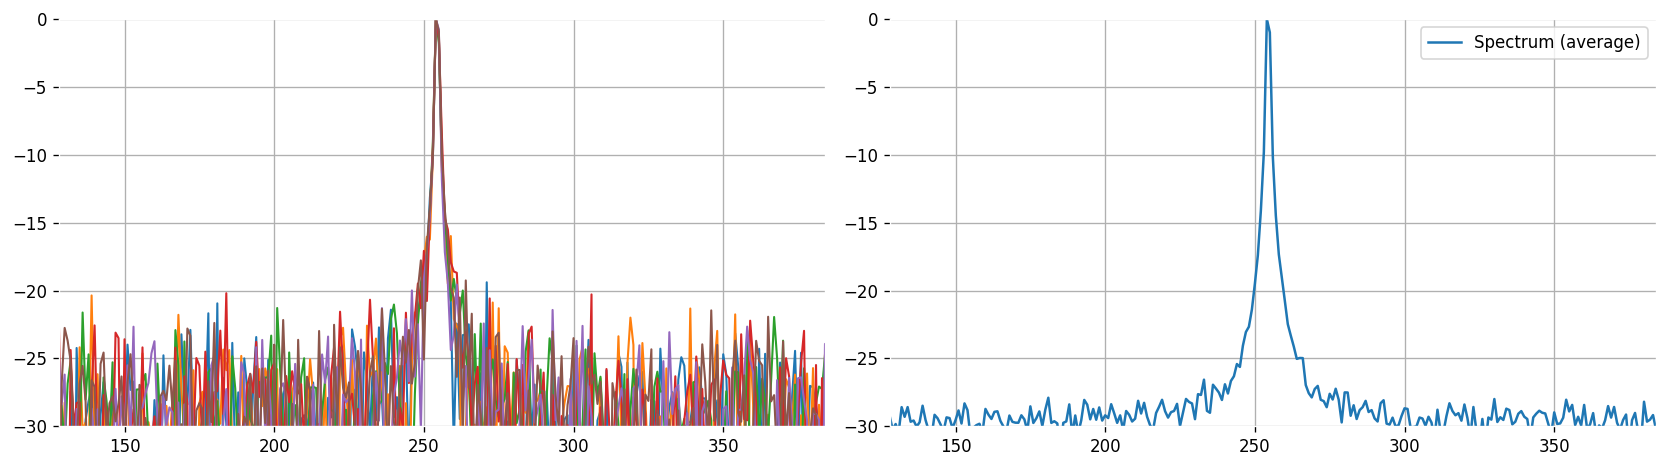

In [10]:
def freq_only(l=32, n=512):
    # Initial Parameters
    m = l*n
    freq = l*(n/4 - 1.5374)

    # Input signal
    np.random.seed(42)
    x = np.cos(2*np.pi*freq*np.linspace(0, 1, m)) + np.random.normal(0, 4*1e-1, m)
    x = x.reshape(l, n)

    y1 = np.abs(fft(x, n))
    y2 = y1.sum(axis=0)

    y1log = 20*np.log10(y1.T / y1.max(axis=1))
    y2log = 20*np.log10(y2 / y2.max())

    plt.figure(figsize=(14, 4), dpi=120)
    plt.subplot(1, 2, 1)
    plt.plot(y1log[:n//2,:6], linewidth=1.25)
    plt.ylim([-30, 0])
    plt.xlim([n//4-n//8, n//4+n//8])
    plt.subplot(1, 2, 2)
    plt.plot(y2log[:n//2], label='Spectrum (average)')
    plt.ylim([-30, 0])
    plt.xlim([n//4-n//8, n//4+n//8])
    plt.legend()
    plt.tight_layout()

freq_only(n=1024)

## Polyphase Fast Fourier Transform

Due to the fact that in some cases, when averaging the signal over time, we received a gain in the signal-to-noise ratio, we will try to use this to obtain the best frequency characteristics of the signal.

* Polyphase FFT * refers to the following digital signal processing algorithm:

- the input of the system receives `L` signals by` N` samples (total sample length `M` = `L * N`)\*
- a window function is applied to a sample of length `M`,
- samples of length `N` are summed over samples,
- FFT is calculated from the resulting sample.

\*-there may be no window function overlay in the next step.

The input signal $ x (k), k = 0, ..., M-1 $ of duration $ M $ is multiplied by the window function $ w (k), k = 0, ..., M-1 $. Then the $ x (k) $ signal is split into $ L $ components of $ N $ samples, which are added to each other, forming the total signal $ y (k), k = 0, ..., N-1 $. The Fourier transform is calculated from the received signal.
___
Let's see what the spectrum of the polyphase FFT looks like with a small sample length `N`. Let's set:

- `N` - the length of the original signal,
- `M` - the length of the terms for the polyphase scheme,
- `L` - number of partitions.

The input signal is the sum of two harmonic influences with different frequencies `f1` and` f2`. No noise. The window function does not apply. Let's build the graphs of the spectral modules for the original signal and the signal obtained as a result of splitting into `L` components and further summation in the time domain.

In [11]:
# Number of samples: N
# Number of parts: L
# Total length of signal: M
N, L = 16, 3
M = N*L

# Input signal
t = np.linspace(0, 1, M)
f1, f2 = L, 4*L

x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
y = x.reshape(L, N).sum(0)

# FFT - M size
XM = np.abs(fft(x, M))[:M//2]
XM /= XM.max()

# FFT - N size
XN = np.abs(fft(y, N))[:N//2]
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

The following graph shows two signals in the time and frequency domains:

- original signal of length `N`,
- total signal of length `M`, obtained as a result of the sum of samples `L`.

As you can see, the signal spectra are almost identical.

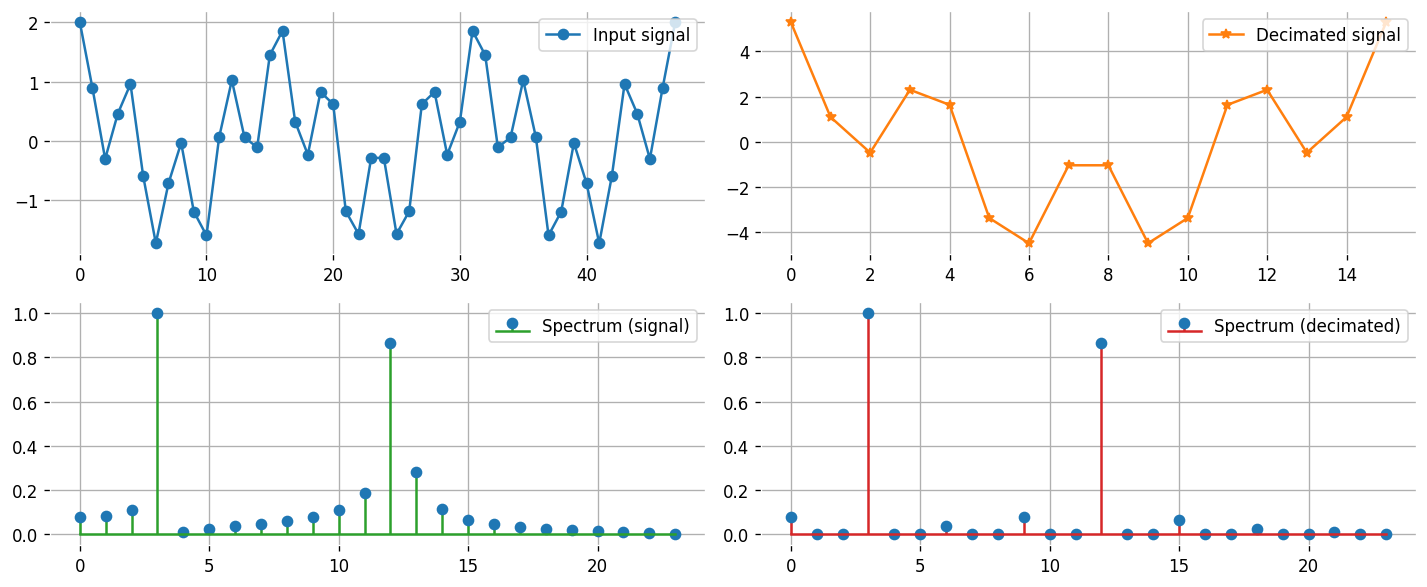

In [12]:
plt.figure(figsize=(12, 5), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

The spectrum of the polyphase FFT is completely equivalent (within the computational error) to the FFT spectrum of the entire sequence, decimated by the number of samples that implement the polyphase algorithm. In other words, the spectrum of the polyphase FFT is equal to the thinned spectrum of the original sequence. The following figure displays this statement.

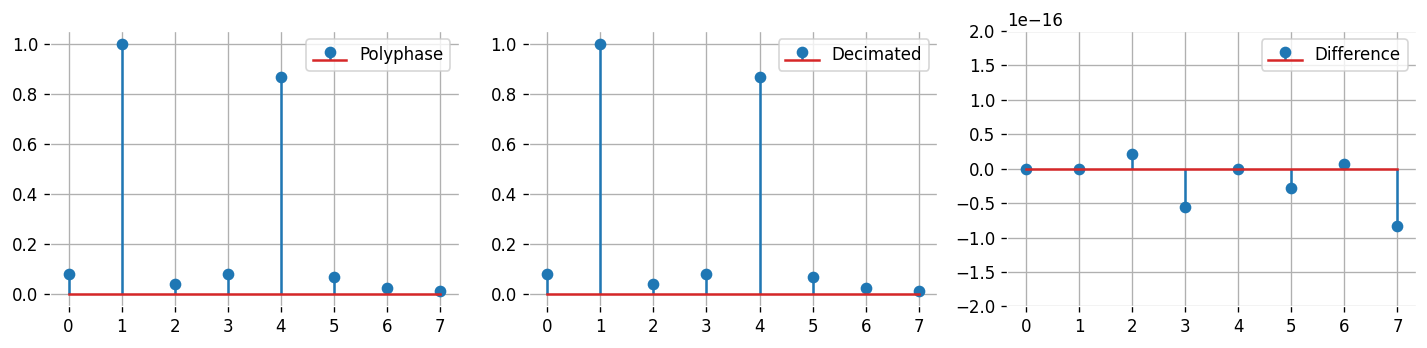

In [13]:
plt.figure(figsize=(12, 3), dpi=120)
plt.subplot(1, 3, 1)
plt.stem(XN, 
         use_line_collection=True, 
         label='Polyphase'
        )
plt.legend(loc='upper right')
plt.subplot(1, 3, 2)
plt.stem(XM[::L], 
         use_line_collection=True, 
         label='Decimated'
        )
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.stem(XN-XM[::L], 
         use_line_collection=True, 
         label='Difference'
        )
plt.ylim(1e-16*np.array([-2, 2]))
plt.legend(loc='upper right')
plt.tight_layout()

## Loss of signal

The fact that the spectra are identical may suggest using a shorter FFT. In particular, this is relevant for highly loaded applications, where the computation time is critical or there are not enough resources to compute long FFT lengths. But is this really so and is this scheme always applicable?

Let's see what happens if the frequency of one of the signals is shifted by 1 sample (in terms of the spectral components of the FFT). In this case, the frequency becomes not a multiple of the split length.

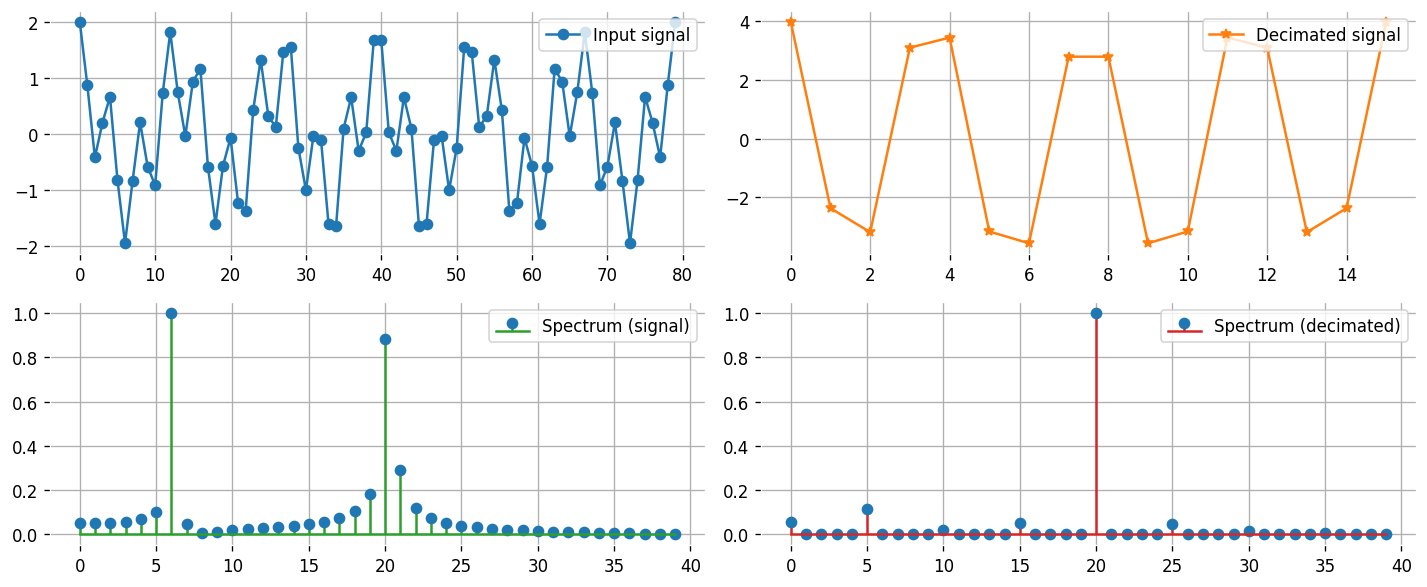

In [14]:
# Input signal
N, L = 16, 5
M = N*L

t = np.linspace(0, 1, M)
f1, f2 = L+1, 4*L

x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
y = x.reshape(L, N).sum(0)

# FFT 
XM = np.abs(fft(x, M))[:M//2]
XN = np.abs(fft(y, N))[:N//2]
XM /= XM.max()
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

plt.figure(figsize=(12, 5), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

As you can see from the following graph, the signal at frequency `f1` has disappeared from the polyphase FFT spectrum. It is known that the spectrum of the polyphase FFT is equal to the decimated spectrum of the original signal. Consequently, as a result of frequency decimation, this spectral component was not included in the sample under consideration (the samples are taken in multiples of `L`).

Earlier, we found out that when the initial phases of the samples that form the total signal do not coincide, the characteristics of such a signal deteriorate. The shape of the signal changes, and the level of the spectral component decreases significantly due to the fact that the amplitude of the total signal decreases.

As a proof, let us plot the graphs of signals at frequencies `f1` and` f2` in the time domain before and after summation.

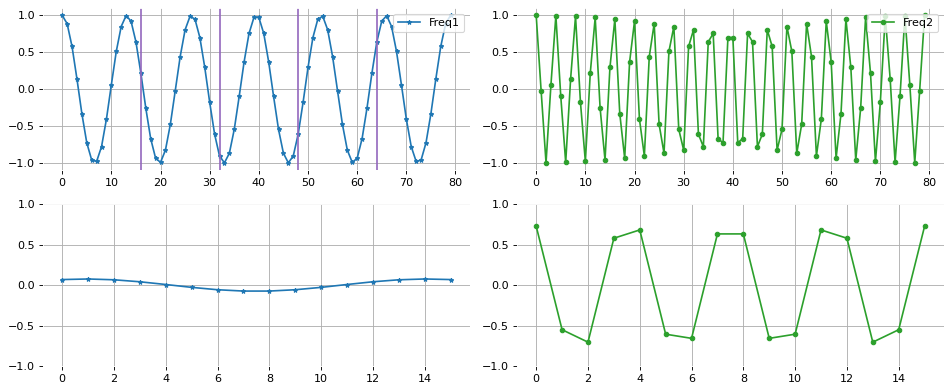

In [15]:
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(2, 2, 1)
plt.plot(np.cos(2*np.pi*f1*t), '-*', markersize=4, color='C0', label='Freq1')
for i in range(1, L):
    plt.axvline(i*N, color='C4', linewidth=1.5)
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(np.cos(2*np.pi*f2*t), '-o', markersize=4, color='C2', label='Freq2')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(np.cos(2*np.pi*f1*t).reshape(L, N).sum(0) / L, '-*', markersize=4, color='C0', label='Freq1')
plt.ylim([-1, 1])

plt.subplot(2, 2, 4)
plt.plot(np.cos(2*np.pi*f2*t).reshape(L, N).sum(0) / L, '-o', markersize=4, color='C2', label='Freq2')
plt.ylim([-1, 1])
plt.tight_layout()

## Window functions

Earlier we found out that the spectrum of a polyphase signal (polyphase FFT) is equivalent to the sparse spectrum of the entire sequence (the decimation factor is `L`). When using signals, the frequency of which is not a multiple of `L`, information is lost in the resulting spectrum. In order to avoid signal loss, let's try to use a window function that "smears" the signal spectrum in frequency.

For this purpose, we will try to use a window function with a flat top `flattop window`.

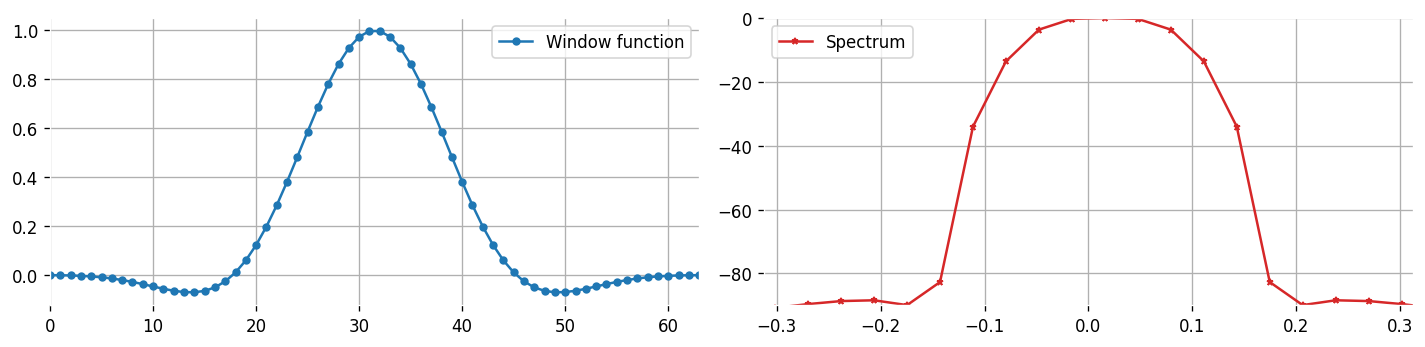

In [16]:
# Window function: flattop
Nfft = 64

win_freq = np.linspace(-1, 1, Nfft)
win_flat = flattop(Nfft) # from scipy

win_ffts = fftshift(np.abs(fft(win_flat, Nfft)))
win_ffts = win_ffts / np.amax(win_ffts, axis=0) + np.nextafter(0,1)
win_logs = 20*np.log10(win_ffts)

# Plot results
plt.figure(figsize=(12, 3), dpi=120)
plt.subplot(1, 2, 1)
plt.plot(win_flat, '-o', markersize=4, label='Window function')
plt.legend(loc='upper right')
plt.xlim([0, Nfft-1])

plt.subplot(1, 2, 2)
plt.plot(win_freq, win_logs,'-*', markersize=4, color='C3', label='Spectrum')
plt.xlim([-20/Nfft, 20/Nfft])
plt.ylim([-90, 0])
plt.legend(loc='upper left')
plt.tight_layout()

Let's multiply the total signal of duration `N` by the window function. Then we split this signal into `L` samples by` N` samples. From the sum of the obtained samples, we calculate the FFT of length `M`.

After multiplying the original signal by the window function, the resulting spectral components are expanded. Ideally, it is necessary to choose such a "expansion" so that not a single spectral reading is lost.

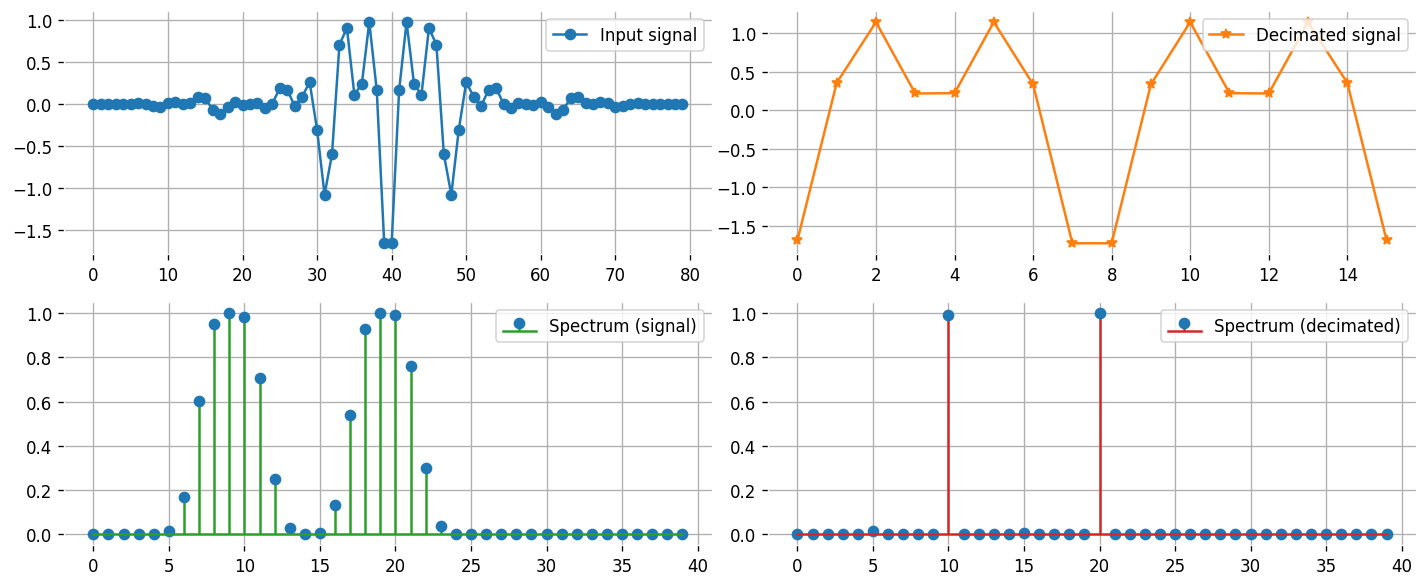

In [17]:
N, L = 16, 5
M = N*L

# Input signal + Window Function
#wn = kaiser(M, beta=13)
wn = flattop(M)

t = np.linspace(0, 1, M)
f1, f2 = 2*L-1, 4*L-1
x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
x *= wn
y = x.reshape(L, N).sum(0)

# FFT - M size
XM = np.abs(fft(x, M))[:M//2]
XM /= XM.max()

# FFT - N size
XN = np.abs(fft(y, N))[:N//2]
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

plt.figure(figsize=(12, 5), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

As you can see, the use of the window function allowed not to lose information on the frequencies `f1` and `f2`, despite the fact that both are not multiples of the number of partitions `L`.

## Examples of polyphase FFT

The following are various combinations of performing time averaging and then calculating the FFT. Let's consider the main features.

In [18]:
def calculate_ffts(f1, f2, n, step, beta=7, use_win=False):
    # Time vector
    m = n*step
    t = np.linspace(0, 1, m)
    # Add AWGN
    np.random.seed(42)
    awgn = np.random.normal(0, 2*1e-3, m)
    # Signal, window function, polyphase FFTs
    wn = kaiser(m, beta=beta)
    x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t) + awgn
    
    y = (x * wn).reshape(step, n).sum(0)

    if use_win:
        x *= wn

    # FFT - M size
    XW = np.abs(fft(x, n))[:n//2]
    XW /= XW.max()
    # FFT - N size
    XN = np.abs(fft(y, n))[:n//2]
    XN /= XN.max()
    # Log spectrum
    XWlog = 20*np.log10(XW / XW.max())
    XNlog = 20*np.log10(XN / XN.max())
    
    return XWlog, XNlog

nfft, step = 2048, 4
Xw = np.zeros([6, nfft//2])
Xn = np.zeros([6, nfft//2])

Xw[0], Xn[0] = calculate_ffts(182, 312, nfft, step, use_win=True)
Xw[1], Xn[1] = calculate_ffts(184, 312, nfft, step)
Xw[2], Xn[2] = calculate_ffts(184, 312, nfft, step, beta=150)
Xw[3], Xn[3] = calculate_ffts(184, 192, nfft, step, beta=300)
Xw[4], Xn[4] = calculate_ffts(184, 200, nfft, step, beta=1)
Xw[5], Xn[5] = calculate_ffts(185, 191, nfft, step)

xs_titles = ['Loss signal at 1st freq', 
             'Determine both freqs',
             'Change window function',
             'Bad window function',
             'No window function',
             'Improve freq resolution',
            ]

We will consider the sum of two harmonic signals with the addition of white noise. Before calculating the polyphase FFT, the Kaiser window function with the variable parameter `beta` is always superimposed, but for comparison, there may be no window overlay on the original signal. For the convenience of plotting graphs, a special function has been written that takes the following parameters as input:

- `f1`,` f2` - frequencies of harmonic vibrations,
- `nfft` - FFT length,
- `step` - the number of averaging (equivalent to the `l` parameter),
- `use_win` - use the Kaiser window function (True / False)
- `beta` - parameter of the Kaiser window function.

Parameters: FFT length `nfft = 2048` and the number of averaging `step = 4` do not change.

Results:  
1.`f1 = 182`, `f2 = 312` - signal loss at the first frequency (non-multiple splitting) due to the wrong choice of the window function (the spectrum does not expand, the initial phases of the summed components are different),  
2.`f1 = 184`, `f2 = 312` - improvement of the signal-to-noise ratio due to the exact hit of frequencies (the initial phases of the summed components are the same, signal distortion does not occur, the level does not fall),  
3.` f1 = 184`, `f2 = 312`,` beta = 150` - when the parameter `beta` increases, the spectral components expand, which can lead to indistinguishability of signals (see below),  
4. `f1 = 184`,` f2 = 192`, `beta = 300` - due to the wrong choice of the parameter of the window function, there was an overlap of two adjacent harmonics. In this case, it is impossible to distinguish between two signals during polyphase processing.  
5.` f1 = 184`, `f2 = 192`,` beta = 1` - the absence of window filtering, as expected, leads to the coincidence of the spectrum of the original signal and the spectrum of the signal during polyphase processing.  
6. `f1 = 185`,` f2 = 191` - the signals are shifted even closer to each other. In the case of polyphase processing with a correctly selected parameter of the window function, it is possible to obtain distinguishability of two harmonics, but in the original spectrum these harmonics merge into one.

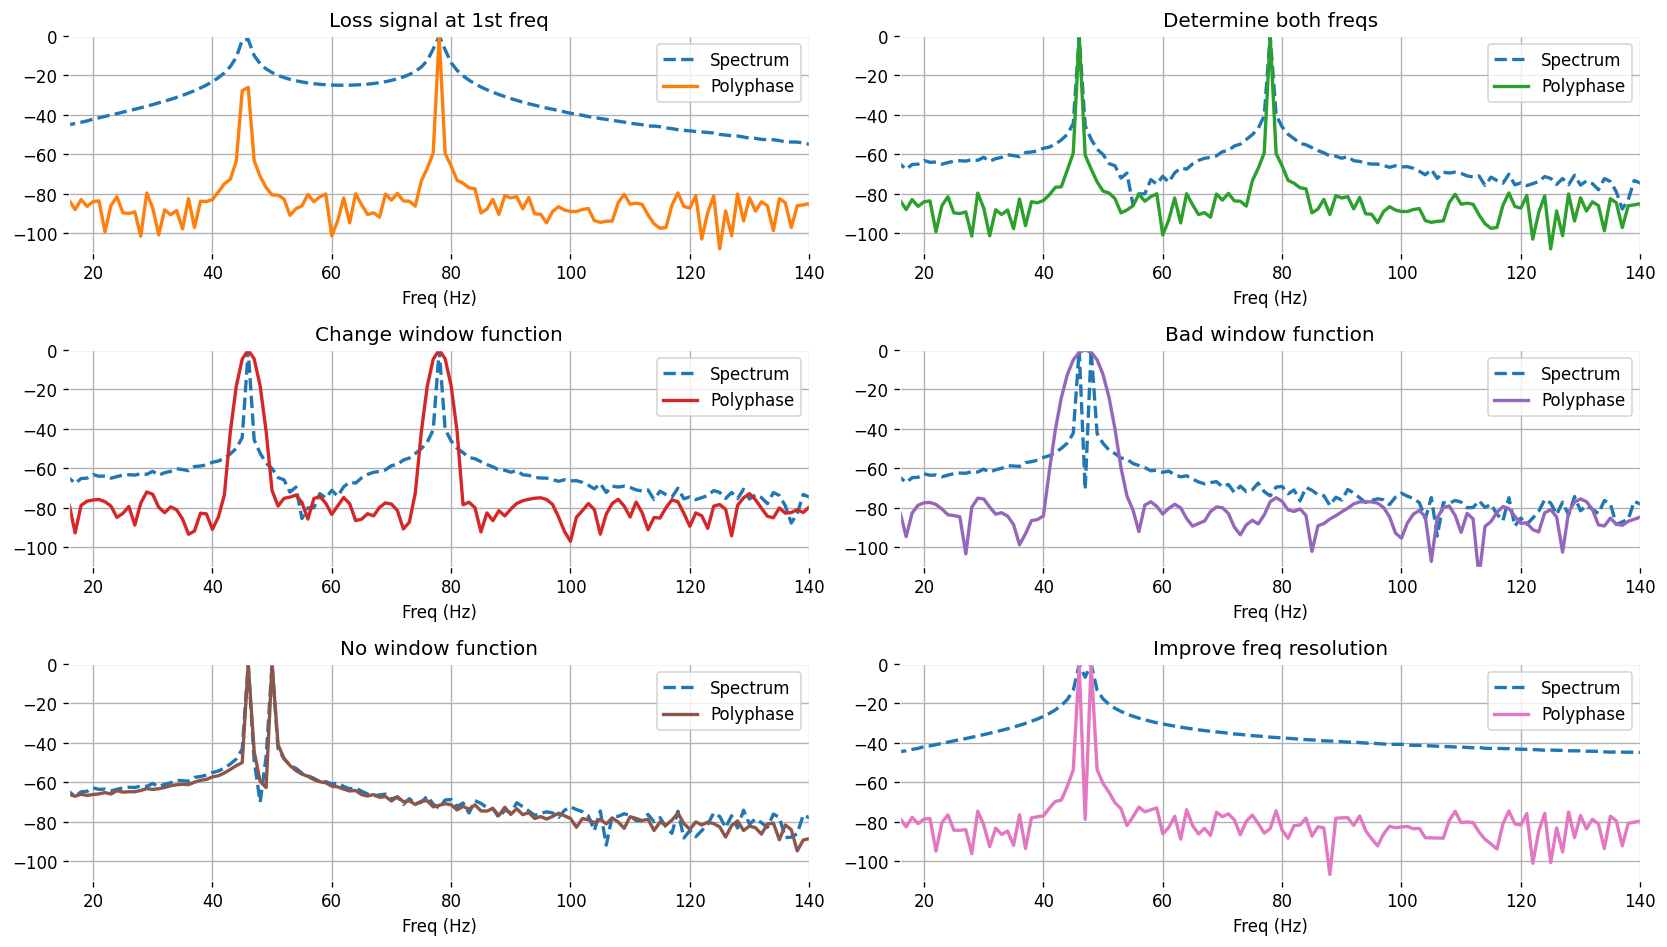

In [19]:
plt.figure(figsize=(14, 8), dpi=120)
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.title(xs_titles[i])
    plt.plot(Xw[i], '--', linewidth=2, label='Spectrum')
    plt.plot(Xn[i], label='Polyphase', linewidth=2, color='C'+str(1+i))
    plt.xlim([16, 140])
    plt.ylim([-110, 0])
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper right')
    plt.tight_layout()

## Conclusions

The physical nature * of the improvement * of the characteristics of signals when they are averaged is expressed in an increase ** in the observation time ** for the process. The longer we observe a physical phenomenon, the more information we can give about it. Based on this, a number of conclusions can be drawn that will help to better understand the possibilities of using one or another signal averaging algorithm.

- The use of ** frequency averaging ** allows you to get a high-quality representation of the signal spectrum module, reducing noise emissions.
- Deterministic signals do not change their level in amplitude, and random noise components are smoothed out during averaging.
- Using ** time averaging ** leads to different results and in general should be used with great care:
    * the spectrum of the polyphase FFT coincides with the sparse spectrum of the original (long) sequence,
    * if the initial phases of the harmonic signals involved in the summation do not match, the resulting signal is distorted. This is reflected in the waveform in the time domain as well as in the signal level,
    * if the initial phases of the harmonic signals coincide, it is possible to obtain * better * indicators of the signal-to-noise ratio and * visually * get the best resolution,
    * For high-quality use of the polyphase FFT, it is recommended to use window functions with correctly selected parameters that affect the signal spectrum width.

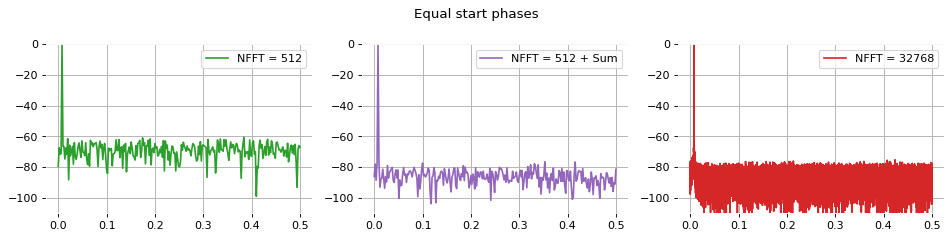

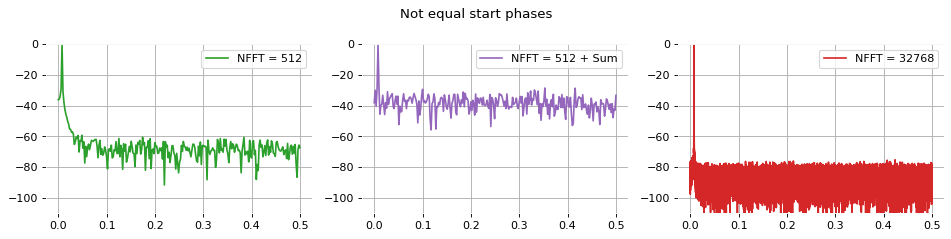

In [20]:
def signals_compare(freq=280, suptitle=''):
    N, L = 512, 64
    M = N*L

    # Input signal
    np.random.seed(42)
    x1 = np.cos(2*np.pi*freq*np.linspace(0, 1, M)) + np.random.normal(0, 5*1e-3, M)
    x2 = np.copy(x1[:N])
    x3 = x1.reshape(L, N).sum(0)
    
    # FFT - M size
    XM = np.abs(fft(x1, M))[:M//2]
    XN = np.abs(fft(x2, N))[:N//2]
    XS = np.abs(fft(x3, N))[:N//2]

    XNlog = 20*np.log10(XN / XN.max())
    XMlog = 20*np.log10(XM / XM.max())
    XSlog = 20*np.log10(XS / XS.max())
    
    fn = np.linspace(0, 0.5, N//2)
    fm = np.linspace(0, 0.5, M//2)
    
    plt.figure(figsize=(12, 3), dpi=80)
    plt.suptitle(suptitle)
    plt.subplot(1, 3, 1)
    plt.plot(fn, XNlog, color='C2', label=f'NFFT = {N}')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.plot(fn, XSlog, color='C4', label=f'NFFT = {N} + Sum')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 3)
    plt.plot(fm, XMlog, color='C3', label=f'NFFT = {M}')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    plt.tight_layout()

signals_compare(freq=256, suptitle='Equal start phases')
signals_compare(freq=258, suptitle='Not equal start phases')